In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx

sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_analysis.get_good_reversal_info import *
from src.behavior_analysis.get_choice_probs_around_good_reversals import *
from src.behavior_visualization.plot_num_reversals import *

In [2]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica Neue", "Helvetica", "Arial"]

In [3]:
root = "../data/cohort-02/rawdata/"
subjects_data = import_data(root)

[INFO] Processed 6 subjects(s), 90 session(s).


In [4]:
subjects_trials = extract_trials(subjects_data)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[INFO] Merging multiple files for subject MY_05_N, session ses-2_date-20260111
[INFO] Merging multiple files for subject MY_05_L, session ses-8_date-20260114
[INFO] Merging multiple files for subject MY_05_L, session ses-9_date-20260115


In [5]:
reversal_windows = get_good_reversal_info(subjects_trials, pre=10, post=40)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[SKIP] MY_05_L reversal@401 (block 8): reward magnitudes before reversal were [4, 0, 0] across towers ['A3', 'A1', 'C3'] (expected a permutation of [4, 1, 0])


In [7]:
x, per_subject, across = get_choice_probs_around_good_reversals(reversal_windows, pre=10, post=40)

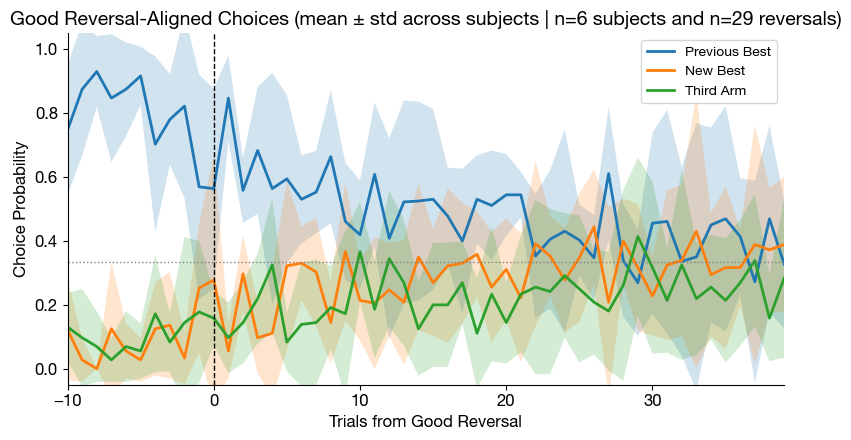

In [8]:
from src.behavior_visualization.plot_choice_probs_around_good_reversals import plot_reversal_probs_around_good_reversals

plot_reversal_probs_around_good_reversals(x, across)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def _classify_towers_from_rewards(reversal):
    before = reversal["reward_magnitudes_by_tower_before"]
    after  = reversal["reward_magnitudes_by_tower_after"]

    prev_best = max(before, key=before.get)
    new_best  = max(after,  key=after.get)

    towers = set(before.keys())
    third = list(towers - {prev_best, new_best})[0]
    return prev_best, new_best, third

def _chosen_tower_from_onehots(reversal, trial_idx, towers):
    """
    Given a trial index into the concatenated window and towers,
    infer which tower was chosen using one-hot arrays in choices_by_tower.
    Returns tower name or None if cannot infer.
    """
    vals = []
    for t in towers:
        # choices_by_tower[t] has "pre" and "post" lists; we'll pass trial_idx relative to post only below
        vals.append(reversal["choices_by_tower"][t]["post"][trial_idx])
    # Expect exactly one 1; fall back to argmax
    if all(v is None for v in vals):
        return None
    j = int(np.nanargmax(np.asarray(vals, dtype=float)))
    return towers[j]

def first_leave_choice_stats(reversal_windows):
    """
    Returns per_subject counts:
      per_subject[subj] = {
        "new_best": int,
        "third": int,
        "no_leave": int,
        "total": int
      }
    """
    per_subject = {}

    for subj, revs in reversal_windows.items():
        counts = {"new_best": 0, "third": 0, "total": 0}

        for r in revs:
            prev_best, new_best, third = _classify_towers_from_rewards(r)
            towers = [prev_best, new_best, third]  # fixed ordering for inference

            post_len = len(r["choices_by_tower"][prev_best]["post"])

            first_non_prev = None
            for j in range(post_len):
                chosen = _chosen_tower_from_onehots(r, j, towers)
                if chosen is None:
                    continue
                if chosen != prev_best:
                    first_non_prev = chosen
                    break

            counts["total"] += 1
            if first_non_prev == new_best:
                counts["new_best"] += 1
            elif first_non_prev == third:
                counts["third"] += 1
            else:
                # Shouldn't happen with 3 towers, but keep it safe
                counts["no_leave"] += 1

        per_subject[subj] = counts

    return per_subject

def plot_first_leave_choice_bar(per_subject_counts, include_no_leave=False):
    """
    Grouped bar plot per subject: fraction of reversals where first leave goes to new_best vs third.
    If include_no_leave=True, plot a third bar for no_leave.
    """
    subjects = sorted(per_subject_counts.keys())
    x = np.arange(len(subjects))
    width = 0.35

    new_frac = []
    third_frac = []
    no_leave_frac = []

    for s in subjects:
        c = per_subject_counts[s]
        denom = c["total"] if c["total"] > 0 else 1
        new_frac.append(c["new_best"] / denom)
        third_frac.append(c["third"] / denom)

    fig, ax = plt.subplots(figsize=(10, 4.5))

    if include_no_leave:
        width = 0.25
        ax.bar(x - width, new_frac, width=width, label="New Best", edgecolor="black", alpha=0.8)
        ax.bar(x,         third_frac, width=width, label="Third Arm", edgecolor="black", alpha=0.8)
    else:
        ax.bar(x - width/2, new_frac, width=width, label="New Best", edgecolor="black", alpha=0.8)
        ax.bar(x + width/2, third_frac, width=width, label="Third Arm", edgecolor="black", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(subjects, rotation=45, ha="right")
    ax.set_ylabel("Fraction of good reversals")
    ax.set_title("First choice after leaving previous best")
    ax.legend()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax


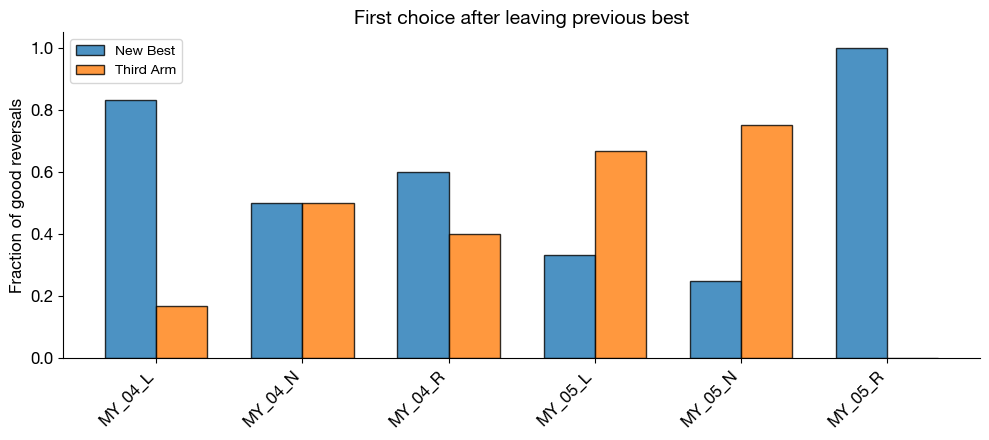

(<Figure size 1000x450 with 1 Axes>,
 <Axes: title={'center': 'First choice after leaving previous best'}, ylabel='Fraction of good reversals'>)

In [14]:
per_subj_counts = first_leave_choice_stats(reversal_windows)
plot_first_leave_choice_bar(per_subj_counts, include_no_leave=False)

# Optional: include "no leave" as a third bar
# plot_first_leave_choice_bar(per_subj_counts, include_no_leave=True)


In [39]:
import numpy as np

def average_first_leave_across_subjects(per_subject_counts, include_no_leave=False):
    """
    Returns:
      mean: dict[label] -> float
      std:  dict[label] -> float
      n_subjects: int
    """
    new_vals = []
    third_vals = []
    no_leave_vals = []

    for subj, c in per_subject_counts.items():
        if c["total"] == 0:
            continue

        new_vals.append(c["new_best"] / c["total"])
        third_vals.append(c["third"] / c["total"])
        no_leave_vals.append(c["no_leave"] / c["total"])

    mean = {
        "new_best": np.mean(new_vals),
        "third": np.mean(third_vals),
    }
    std = {
        "new_best": np.std(new_vals, ddof=1) if len(new_vals) > 1 else 0.0,
        "third": np.std(third_vals, ddof=1) if len(third_vals) > 1 else 0.0,
    }

    if include_no_leave:
        mean["no_leave"] = np.mean(no_leave_vals)
        std["no_leave"] = np.std(no_leave_vals, ddof=1) if len(no_leave_vals) > 1 else 0.0

    return mean, std, len(new_vals)


In [40]:
import matplotlib.pyplot as plt

def plot_avg_first_leave(mean, std, n_subjects, include_no_leave=False):
    labels = ["New best", "Third arm"]
    means = [mean["new_best"], mean["third"]]
    errs = [std["new_best"], std["third"]]

    if include_no_leave:
        labels.append("No leave")
        means.append(mean["no_leave"])
        errs.append(std["no_leave"])

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(4.5, 4))

    ax.bar(
        x,
        means,
        yerr=errs,
        capsize=6,
        edgecolor="black",
        alpha=0.8
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Fraction of good reversals")
    ax.set_title(f"First choice after leaving previous best\n(mean ± SD across subjects, n={n_subjects})")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax


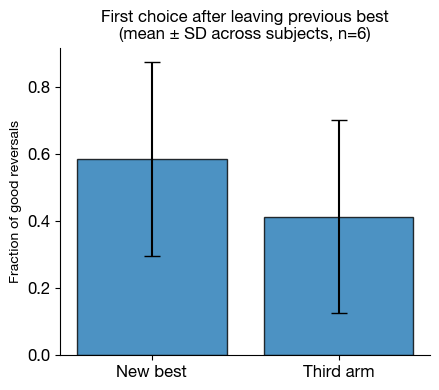

(<Figure size 450x400 with 1 Axes>,
 <Axes: title={'center': 'First choice after leaving previous best\n(mean ± SD across subjects, n=6)'}, ylabel='Fraction of good reversals'>)

In [41]:
per_subject_counts = first_leave_choice_stats(reversal_windows)

mean, std, n_subjects = average_first_leave_across_subjects(
    per_subject_counts,
    include_no_leave=False
)

plot_avg_first_leave(mean, std, n_subjects)


In [45]:
from scipy.stats import ttest_rel, wilcoxon

def paired_test_first_leave(per_subject_counts, method="ttest"):
    new_vals = []
    third_vals = []

    for c in per_subject_counts.values():
        if c["total"] == 0:
            continue
        new_vals.append(c["new_best"] / c["total"])
        third_vals.append(c["third"] / c["total"])

    new_vals = np.array(new_vals)
    third_vals = np.array(third_vals)

    if method == "wilcoxon":
        stat, p = wilcoxon(new_vals, third_vals)
        test_name = "Wilcoxon signed-rank"
    else:
        stat, p = ttest_rel(new_vals, third_vals)
        test_name = "Paired t-test"

    return {
        "test": test_name,
        "stat": stat,
        "p": p,
        "n_subjects": len(new_vals),
        "new_vals": new_vals,
        "third_vals": third_vals,
    }


In [46]:
def plot_avg_first_leave_with_subjects(mean, std, per_subject_counts):
    subjects = list(per_subject_counts.keys())

    new_vals = np.array([
        per_subject_counts[s]["new_best"] / per_subject_counts[s]["total"]
        for s in subjects if per_subject_counts[s]["total"] > 0
    ])
    third_vals = np.array([
        per_subject_counts[s]["third"] / per_subject_counts[s]["total"]
        for s in subjects if per_subject_counts[s]["total"] > 0
    ])

    x = np.array([0, 1])

    fig, ax = plt.subplots(figsize=(4.5, 4))

    # Bars
    ax.bar(
        x,
        [mean["new_best"], mean["third"]],
        yerr=[std["new_best"], std["third"]],
        capsize=6,
        edgecolor="black",
        alpha=0.8,
    )

    # Subject dots + paired lines
    jitter = 0.04
    for nv, tv in zip(new_vals, third_vals):
        ax.plot(
            [0 + np.random.uniform(-jitter, jitter),
             1 + np.random.uniform(-jitter, jitter)],
            [nv, tv],
            color="gray",
            alpha=0.6,
            linewidth=1
        )

    ax.set_xticks(x)
    ax.set_xticklabels(["New best", "Third arm"])
    ax.set_ylabel("Fraction of good reversals")
    ax.set_title("First choice after leaving previous best")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax


In [47]:
def first_leave_early_late(reversal_windows):
    """
    Returns:
      per_subject[subj]["early" | "late"]["new_best" | "third"]
    """
    per_subject = {}

    for subj, revs in reversal_windows.items():
        n = len(revs)
        if n < 2:
            continue

        mid = n // 2
        early = revs[:mid]
        late = revs[mid:]

        def compute(revs_subset):
            counts = {"new_best": 0, "third": 0, "total": 0}
            for r in revs_subset:
                prev_best = max(r["reward_magnitudes_by_tower_before"],
                                key=r["reward_magnitudes_by_tower_before"].get)
                new_best = max(r["reward_magnitudes_by_tower_after"],
                               key=r["reward_magnitudes_by_tower_after"].get)
                third = list(set(r["reward_magnitudes_by_tower_before"]) - {prev_best, new_best})[0]

                post = r["choices_by_tower"]
                for i in range(len(post[prev_best]["post"])):
                    if post[prev_best]["post"][i] == 0:
                        if post[new_best]["post"][i] == 1:
                            counts["new_best"] += 1
                        elif post[third]["post"][i] == 1:
                            counts["third"] += 1
                        counts["total"] += 1
                        break
            return counts

        per_subject[subj] = {
            "early": compute(early),
            "late": compute(late),
        }

    return per_subject


In [48]:
def plot_early_late_first_leave(per_subject_early_late):
    new_early, new_late = [], []
    third_early, third_late = [], []

    for d in per_subject_early_late.values():
        for phase, new_list, third_list in [
            ("early", new_early, third_early),
            ("late", new_late, third_late),
        ]:
            c = d[phase]
            if c["total"] == 0:
                continue
            new_list.append(c["new_best"] / c["total"])
            third_list.append(c["third"] / c["total"])

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot([0, 1], [np.mean(new_early), np.mean(new_late)], label="New best", marker="o")
    ax.plot([0, 1], [np.mean(third_early), np.mean(third_late)], label="Third arm", marker="o")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Early", "Late"])
    ax.set_ylabel("Fraction of first-leave choices")
    ax.set_title("Early vs late reversals")
    ax.legend()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()


0.49787562764548093


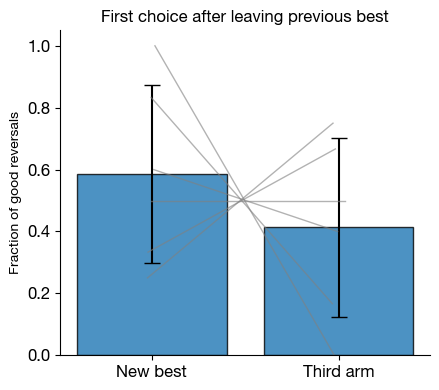

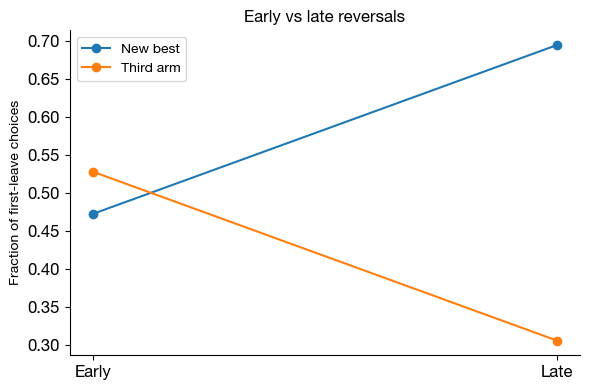

In [56]:
# Per-subject counts
per_subject_counts = first_leave_choice_stats(reversal_windows)

# Stats
stats = paired_test_first_leave(per_subject_counts)
print(stats['p'])

# Mean/std
mean, std, n_subjects = average_first_leave_across_subjects(per_subject_counts)

# Plot with subject dots
plot_avg_first_leave_with_subjects(mean, std, per_subject_counts)

# Early vs late
per_subject_early_late = first_leave_early_late(reversal_windows)
plot_early_late_first_leave(per_subject_early_late)


In [52]:
def first_leave_choice_stats_late_only(reversal_windows):
    """
    Same as first_leave_choice_stats, but only using LATE reversals
    (second half within each subject).
    """
    per_subject = {}

    for subj, revs in reversal_windows.items():
        n = len(revs)
        if n < 2:
            continue

        late_revs = revs[n // 2:]  # late half
        counts = {"new_best": 0, "third": 0, "no_leave": 0, "total": 0}

        for r in late_revs:
            before = r["reward_magnitudes_by_tower_before"]
            after  = r["reward_magnitudes_by_tower_after"]

            prev_best = max(before, key=before.get)
            new_best  = max(after, key=after.get)
            third = list(set(before.keys()) - {prev_best, new_best})[0]

            post_len = len(r["choices_by_tower"][prev_best]["post"])
            first_non_prev = None

            for i in range(post_len):
                if r["choices_by_tower"][prev_best]["post"][i] == 0:
                    if r["choices_by_tower"][new_best]["post"][i] == 1:
                        first_non_prev = "new_best"
                    elif r["choices_by_tower"][third]["post"][i] == 1:
                        first_non_prev = "third"
                    break

            counts["total"] += 1
            if first_non_prev is None:
                counts["no_leave"] += 1
            else:
                counts[first_non_prev] += 1

        per_subject[subj] = counts

    return per_subject


0.1345409200142044


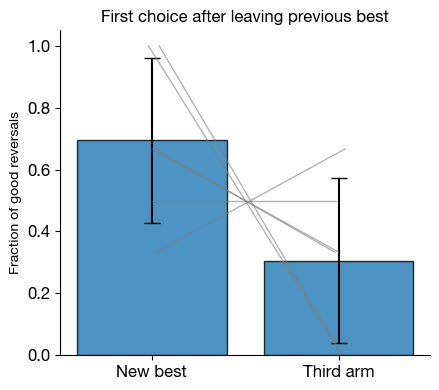

(<Figure size 450x400 with 1 Axes>,
 <Axes: title={'center': 'First choice after leaving previous best'}, ylabel='Fraction of good reversals'>)

In [55]:
# Late-only per-subject counts
per_subject_counts_late = first_leave_choice_stats_late_only(reversal_windows)

# Stats
stats_late = paired_test_first_leave(per_subject_counts_late)
print(stats_late['p'])

# Mean ± SD
mean_late, std_late, n_subjects_late = average_first_leave_across_subjects(
    per_subject_counts_late
)

# Plot
plot_avg_first_leave_with_subjects(
    mean_late,
    std_late,
    per_subject_counts_late
)
